In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.models import load_model
import datetime
from scipy.io import wavfile
from sklearn.preprocessing import StandardScaler
from pydub import AudioSegment
from scipy.signal import resample

C:\Users\syj47\anaconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
data = pd.read_csv('Beep.csv')
train_data = data['0'].values/1000
print(data['0'].describe())
print(train_data)

count    365722.000000
mean          0.101553
std       14621.656175
min      -30058.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       30055.000000
Name: 0, dtype: float64
[0. 0. 0. ... 0. 0. 0.]


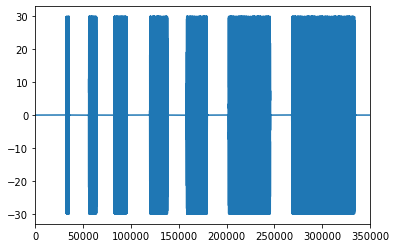

In [3]:
plt.plot(train_data)
plt.xlim(0,350000)
plt.show()

In [4]:
# 5초 간의 데이터를 보고 다음을 예측
seq_len = 50  #예측을 위한 데이터 수
prediction = 1  # 다음을 예측할 데이터 수 
print("seq_len : ", seq_len)
sequence_length = seq_len + prediction

seq_len :  50


In [5]:
# 정확한 예측을 위해 값들을 정규화 
result = []
for index in range(len(train_data) - sequence_length):
    result.append(train_data[index: index + sequence_length])
result = np.array(result)

# 트레이닝할 값과 테스트 값을 나눠줌
row = int(round(result.shape[0] * 0.1))
train = result[:row, :]

x_train = train[:, :-prediction]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -prediction]

x_test = result[row:, :-prediction]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -prediction]


In [6]:
# 모델 생성
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(50,1)))  # (timestep, feature)
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='rmsprop', metrics=["acc"])
model.summary()

# 트레이닝 값으로 학습
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=10, epochs=30)

# 모델 저장
model.save('weight.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
3657/3657 [==============================] - 260s 70ms/step - loss: 6.5015 - acc: 0.8952 - val_loss: 0.4484 - val_acc: 0.4597
Epoch 2/30
3657/3657 [==============================] - 281s 77ms/step - loss: 0.0935 - acc: 0.8996 - val_loss: 0.2121 - val_acc: 0.4597
Epoch 3/30
3657/3657 [==============================] - 281s 77ms/step - loss: 0.0519 - acc: 0.8975 - val_lo

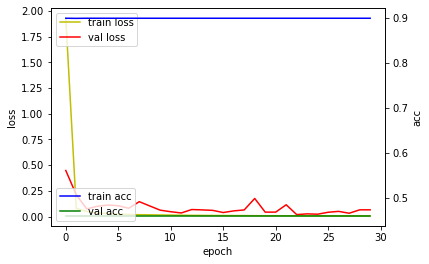

In [7]:
# 모델 학습 과정 표시
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('acc')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [8]:
# 모델 로드
model = Sequential()
model = load_model('weight.h5')

In [9]:
pred = model.predict(x_test)
pred

array([[-0.00129695],
       [-0.00129695],
       [-0.00129695],
       ...,
       [-0.00129695],
       [-0.00129695],
       [-0.00129695]], dtype=float32)

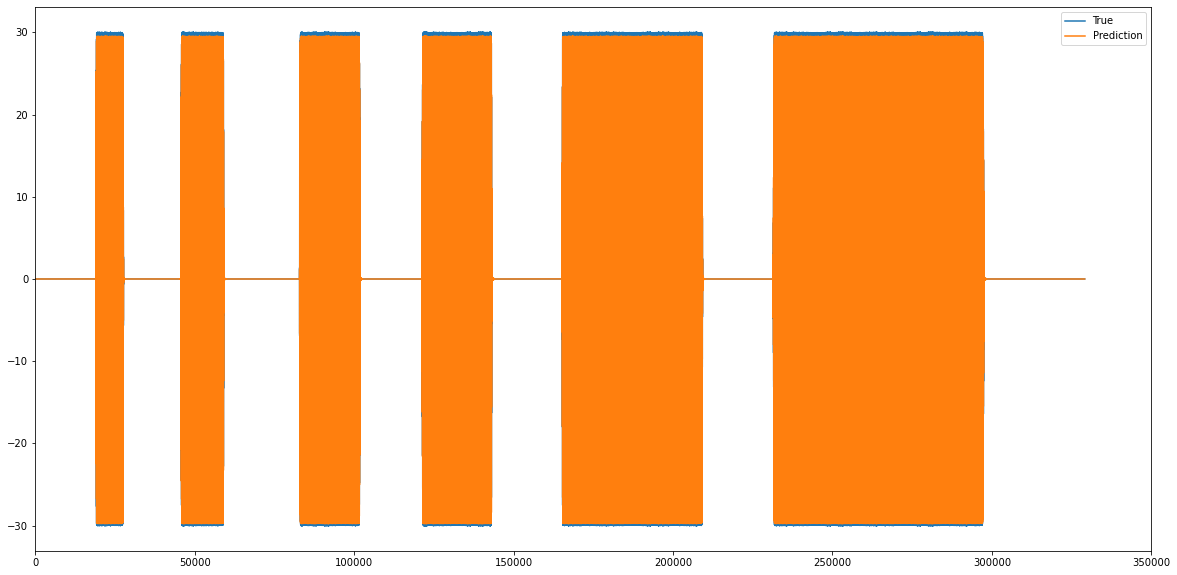

In [10]:
# 그래프 
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.xlim(0,350000)
plt.show()

In [11]:
# 예측값을 wav로 출력
EXPECTED_SAMPLE_RATE = 44100
pred = pred * 1000 / EXPECTED_SAMPLE_RATE
y_test = y_test * 1000 / EXPECTED_SAMPLE_RATE

wavfile.write("pred.wav", EXPECTED_SAMPLE_RATE, pred)
wavfile.write("y_test.wav", EXPECTED_SAMPLE_RATE, y_test)
print("end")

end
